In [1]:
# 1. Import packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os,datetime

In [2]:
# 2. Data loading
PATH = r"C:\Users\zahiz\Desktop\Capstone_Concretecrackimages\dataset\Concrete Crack Images for Classification"

In [3]:
train_dir = os.path.join(PATH)
validation_dir = os.path.join(PATH)

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            seed=42)


Found 40000 files belonging to 2 classes.
Using 32000 files for training.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=0.2,
                                                                subset='validation',
                                                                seed=42)

Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


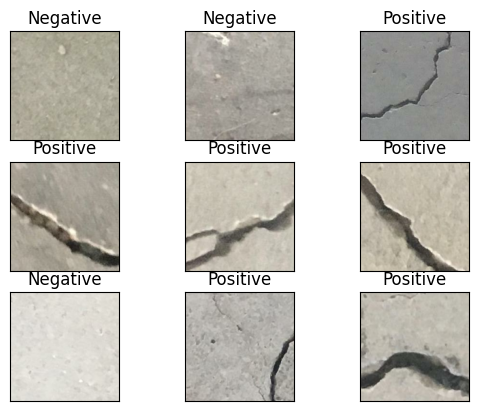

In [5]:
# 3. Inspect some of the data
class_names = train_dataset.class_names
batch_1 = train_dataset.take(1)
for images,labels in batch_1:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
plt.show()

In [6]:
# 4. Further split the validation set into val-test splits
nBatches = validation_dataset.cardinality().numpy()
val_dataset = validation_dataset.take(nBatches//2)
test_dataset = validation_dataset.skip(nBatches//2)

In [7]:
# 5. Convert val and test dataset to prefetch dataset
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# 6. Create the data augmentation layers
data_augmentation = keras.Sequential()
data_augmentation.add(keras.layers.RandomFlip('horizontal'))
data_augmentation.add(keras.layers.RandomRotation(0.2))

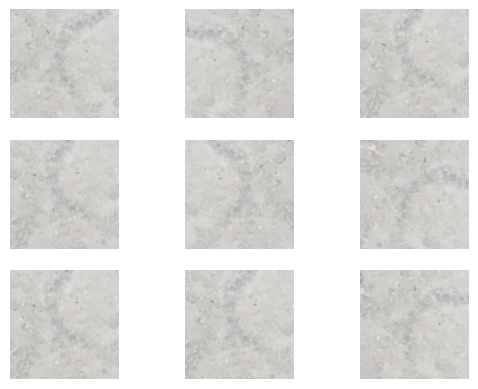

In [9]:
# 7. Let's test out the data augmentation layers
for images,labels in train_dataset.take(1):
    first_image = images[0]
    plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image,axis=0))
        plt.imshow(augmented_image[0]/255.0)
        plt.axis('off')
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
plt.show()

In [10]:
# 8. Create the preprocess input layer for mobilenet v2
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

In [11]:
# 9. Perform transfer learning
# (A) Create the feature extractor from the pretrained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
# Freeze the entire base model so that it will not receive any training (non-trainable)
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# (B) Add in our own classifier
global_avg = keras.layers.GlobalAveragePooling2D()
output_layer = keras.layers.Dense(len(class_names),activation='softmax')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

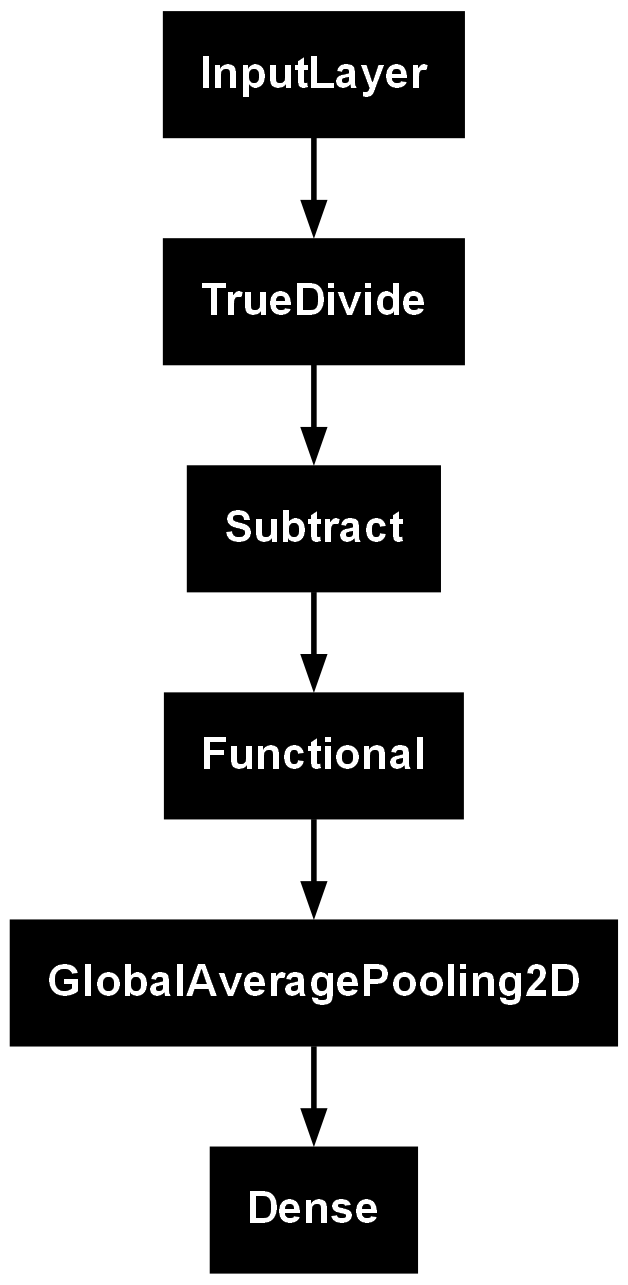

In [13]:
# (C) Use functional API to connect the layers together to form a pipeline
# a. Begin with input
inputs = keras.Input(shape=IMG_SHAPE)
# b. augmentation
# x = data_augmentation(inputs)
# b. preprocess layer
x = preprocess_input(inputs)
# c. feature extractor
x = base_model(x)
# d. classifier
x = global_avg(x)
outputs = output_layer(x)

model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()
keras.utils.plot_model(model)

In [14]:
# 10. Model compile
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [15]:
# Define the callbacks
logpath = "tensorboard/concrete/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)
es = keras.callbacks.EarlyStopping(patience=3,verbose=1)

In [16]:
# Evaluate the model before training
model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.5015 - loss: 1.0517


[1.048743724822998, 0.5042499899864197]

In [17]:
# 11. First stage of training
EPOCHS = 15
history_first = model.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[tb,es])

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 128s 125ms/step - accuracy: 0.9282 - loss: 0.1917 - val_accuracy: 0.9967 - val_loss: 0.0134
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 125s 125ms/step - accuracy: 0.9972 - loss: 0.0122 - val_accuracy: 0.9977 - val_loss: 0.0082
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 120s 120ms/step - accuracy: 0.9981 - loss: 0.0081 - val_accuracy: 0.9980 - val_loss: 0.0074
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 126s 126ms/step - accuracy: 0.9981 - loss: 0.0065 - val_accuracy: 0.9980 - val_loss: 0.0059
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 119s 119ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 0.9980 - val_loss: 0.0055
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 124s 124ms/step - accuracy: 0.9986 - loss: 0.0048 - val_accuracy: 0.9985 - val_loss: 0.0050
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 123s 123ms/step - accuracy: 0.9989 - loss: 0.0042 - val_accuracy: 0.9987 - val_loss: 0.0045
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 126s 126ms/step - ac

In [20]:
evaluate = model.evaluate(test_dataset)

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9988 - loss: 0.0052


In [23]:
# 12. Proceed with second stage of training
# (A) Unfreeze the base model
base_model.trainable = True
# (B) Freeze the earlier layers inside the base model
fine_tune_at = 100
for layer in base_model.layers[:100]:
    layer.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [25]:

# Recompile the model, this time we will choose a different optimizer
rms = keras.optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [26]:
# (C) Run the second stage of training
fine_tune_epoch = 10
total_epoch = EPOCHS + fine_tune_epoch
history_fine = model.fit(train_dataset,validation_data=validation_dataset,epochs=total_epoch,initial_epoch=len(history_first.epoch),callbacks=[tb])

Epoch 13/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 201s 194ms/step - accuracy: 0.9799 - loss: 0.0543 - val_accuracy: 0.9965 - val_loss: 0.0087
Epoch 14/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 192s 192ms/step - accuracy: 0.9974 - loss: 0.0081 - val_accuracy: 0.9989 - val_loss: 0.0036
Epoch 15/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 190s 190ms/step - accuracy: 0.9979 - loss: 0.0051 - val_accuracy: 0.9989 - val_loss: 0.0038
Epoch 16/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 190s 190ms/step - accuracy: 0.9991 - loss: 0.0027 - val_accuracy: 0.9990 - val_loss: 0.0034
Epoch 17/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 191s 191ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9987 - val_loss: 0.0038
Epoch 18/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 191s 191ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9987 - val_loss: 0.0039
Epoch 19/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 191s 191ms/step - accuracy: 0.9997 - loss: 6.4366e-04 - val_accuracy: 0.9989 - val_loss: 0.0036
Epoch 20/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 191s 191

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step
['Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Negative']


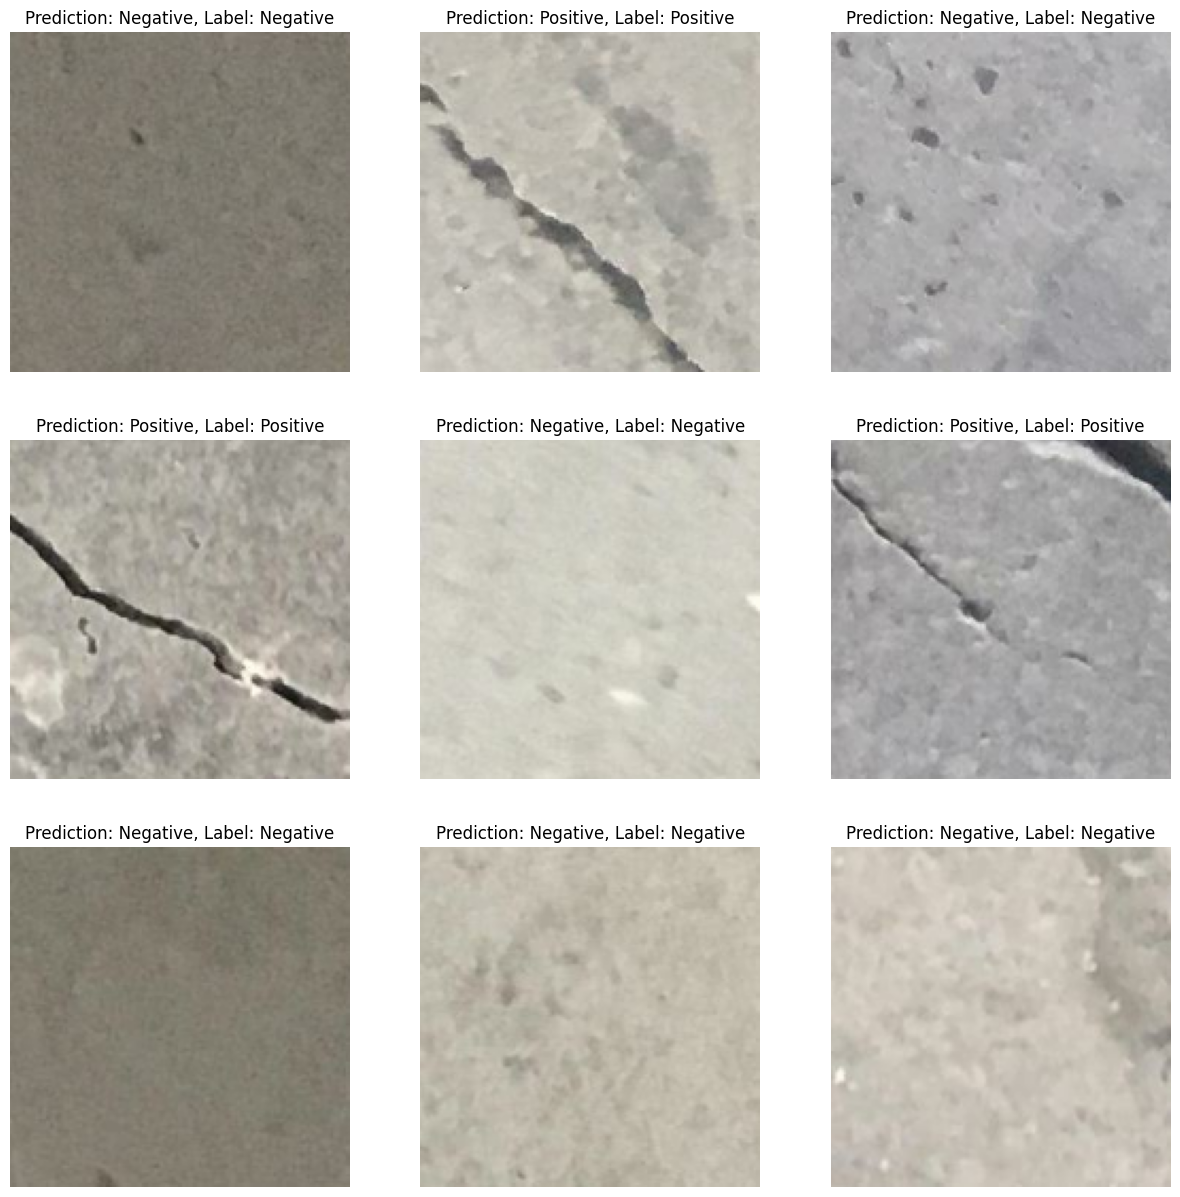

In [27]:
# Make predictions with the test data
for image_batch, label_batch in test_dataset.take(1):
    predictions = np.argmax(model.predict(image_batch),axis=1)
    predicted_class = [class_names[x] for x in predictions]
print(predicted_class)

plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(f"Prediction: {predicted_class[i]}, Label: {class_names[label_batch[i]]}")
plt.show()

In [ ]:
evaluation = model.evaluate(test_dataset)
# The accuracy obtained is 99%

125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.9997 - loss: 6.7808e-04


In [23]:
loss = evaluate[:1]
accuracy = evaluate[1:]
print("Loss is\n",loss)
print("Accuracy is\n",accuracy)

Loss is
 [0.003901963122189045]
Accuracy is
 [0.9990000128746033]


In [24]:
# SAVE THE MODEL 
keras.models.save_model(model,"models/nuclei_detection.h5")